Typical DS packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

from sklearn import datasets

from tqdm.notebook import tqdm

FCA packages

In [2]:
import caspailleur as csp
from paspailleur import pattern_structures as PS

Bitarrays that make operations on extent really fast

In [3]:
from bitarray.util import subset as ba_subset
from bitarray import frozenbitarray

# Clustering Step 1. Get the data

Copy-pasting the code from https://scikit-learn.org/stable/modules/clustering.html

In [4]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
X, y = noisy_circles

In [5]:
from script import visual_lib as vlib

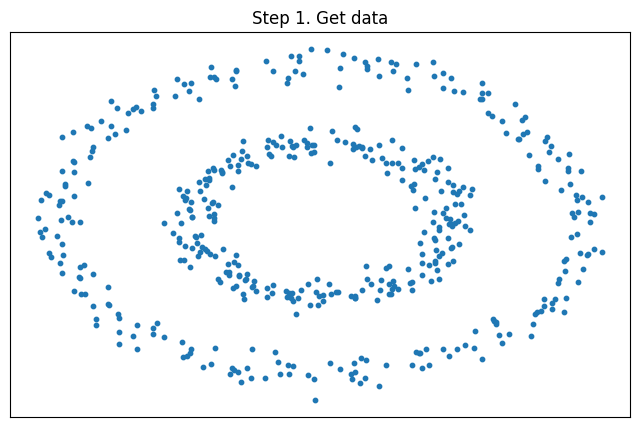

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

vlib.init_axis(ax, 'Step 1. Get data', [], [])
ax.scatter(X[:,0], X[:,1], s=10)

fig.savefig('../figures/pipe_step1_circlesdata.pdf')
plt.show()

# Clustering Step 2. Initialise Pattern Structure

In [7]:
MIN_SUPPORT = 0.1
MIN_STABILITY = 0.01
PRECISION = 6

In [8]:
borders_per_axis = [np.linspace(X[:,j].min(), X[:,j].max(), 11) for j in range(X.shape[1])]
borders_per_axis

[array([-1.06916532e+00, -8.55291825e-01, -6.41418333e-01, -4.27544841e-01,
        -2.13671349e-01,  2.02142295e-04,  2.14075634e-01,  4.27949126e-01,
         6.41822617e-01,  8.55696109e-01,  1.06956960e+00]),
 array([-1.15405765, -0.92828174, -0.70250583, -0.47672992, -0.25095401,
        -0.0251781 ,  0.20059781,  0.42637372,  0.65214963,  0.87792554,
         1.10370145])]

In [9]:
basic_pss = [PS.IntervalPS(values=borders, ndigits=PRECISION) for borders in borders_per_axis]
ps_cart = PS.CartesianPS(basic_pss)
data = list(ps_cart.preprocess_data(X))

In [10]:
assert len(list(ps_cart.extent(data, ps_cart.intent(data)))) == len(data)

In [11]:
from importlib import reload

vlib = reload(vlib)  # to upload changes in the .py file into the Notebook's kernel

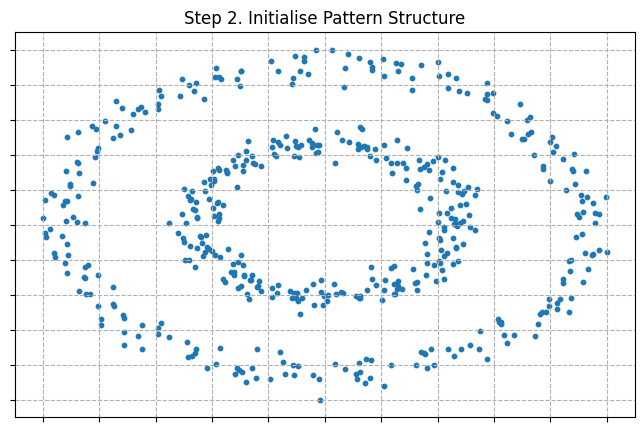

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

vlib.init_axis(ax, 'Step 2. Initialise Pattern Structure', borders_per_axis[0], borders_per_axis[1], [], [], grid_params=dict(zorder=0, linestyle='--'))

ax.scatter(X[:,0], X[:,1], zorder=1, s=10)

fig.savefig('../figures/pipe_step2_circlesdata.pdf')
plt.show()

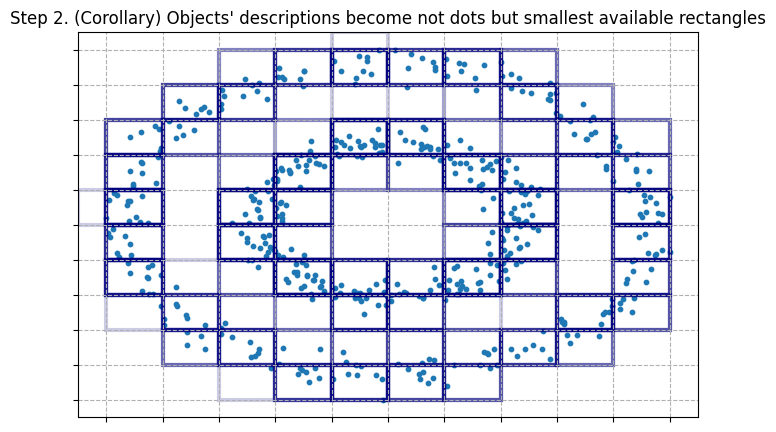

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

vlib.init_axis(ax, "Step 2. (Corollary) Objects' descriptions become not dots but smallest available rectangles", borders_per_axis[0], borders_per_axis[1], [], [], grid_params=dict(zorder=0, linestyle='--'))

ax.scatter(X[:,0], X[:,1], zorder=1, s=10)
for obj_description in data:
    vlib.draw_2d_description(ax, obj_description, patch_params=dict(color='navy', fc='none', alpha=0.2, linewidth=3))

plt.show()

# Clustering Step 3. Compute stable concepts

In [14]:
attributes, attr_extents = zip(*ps_cart.iter_attributes(data, min_support=0.1))
print(f'n attributes: {len(attr_extents)}')
print(f'attribute 0: {attributes[0]}')
print(f'extent of attributes 0: {attr_extents[0]}')

n attributes: 34
attribute 0: (0, (-1.069165, 1.06957, <BoundStatus.CLOSED: 3>))
extent of attributes 0: frozenbitarray('11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111')


In [15]:
%%time
stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_gsofia(
    attr_extents, n_objects=len(data), min_delta_stability=0.01, min_supp=0.1, use_tqdm=True, n_attributes=len(attr_extents)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count(), reverse=True)
print(len(stable_extents))

  0%|          | 0/34 [00:00<?, ?it/s]

1397
CPU times: user 50.2 ms, sys: 12.3 ms, total: 62.6 ms
Wall time: 52.9 ms


In [16]:
%%time
stable_intents = [ps_cart.intent(data, ext.search(True)) for ext in tqdm(stable_extents)]

  0%|          | 0/1397 [00:00<?, ?it/s]

CPU times: user 881 ms, sys: 13.7 ms, total: 895 ms
Wall time: 891 ms


In [17]:
print(f'Stable intent #0: {stable_intents[0]}')
print(f'Stable intent #0 (better readable): {ps_cart.verbalize(stable_intents[0], pattern_names=["x0", "x1"])}')
print(f'Extent of stable intent #0: {stable_extents[0]}')

Stable intent #0: ((-inf, 1.06957, <BoundStatus.CLOSED: 3>), (-1.154058, inf, <BoundStatus.CLOSED: 3>))
Stable intent #0 (better readable): x0: [-∞, 1.07], x1: [-1.15, ∞]
Extent of stable intent #0: frozenbitarray('11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111')


In [18]:
def describe_with_attributes(extent, attr_extents) -> list[int]:
    """Find attribute-based intent for a given extent. So not a 'pattern intent'"""
    return [i for i, attr_extent in enumerate(attr_extents) if ba_subset(extent, attr_extent)]

delta_stabilities = [
    csp.indices.delta_stability_by_description(
        describe_with_attributes(extent, attr_extents), attr_extents)
    for extent in stable_extents
]
stability_per_intent = dict(zip(stable_intents, delta_stabilities))

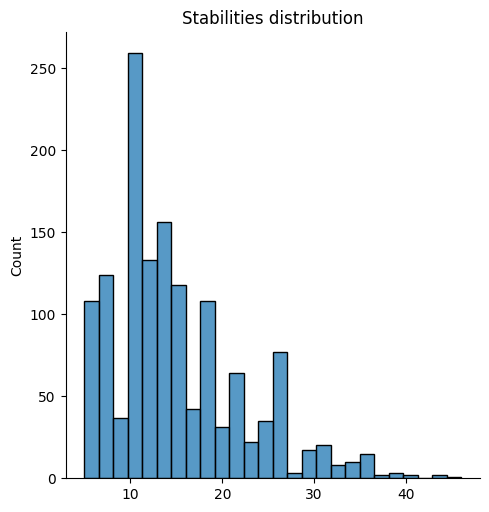

In [19]:
import seaborn as sns

sns.displot(delta_stabilities)
plt.title('Stabilities distribution')
plt.show()

In [20]:
AXES_PARAMS = (
    borders_per_axis[0], 
    borders_per_axis[1], 
    range(len(borders_per_axis[0])), 
    range(len(borders_per_axis[1])), 
    dict(zorder=0, linestyle='--')
)

In [21]:
vlib = reload(vlib)

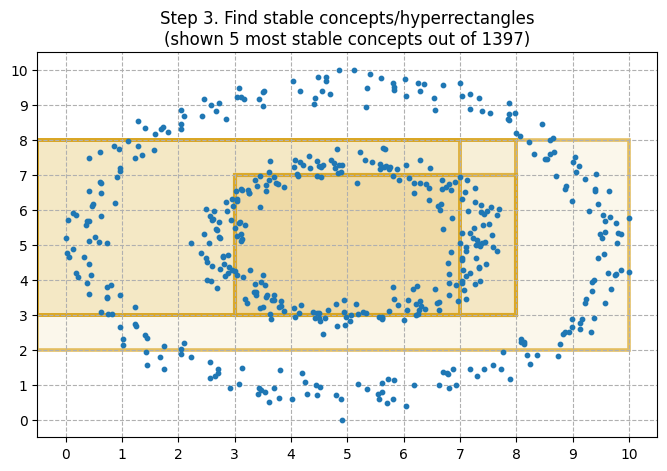

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))

k = 5
vlib.init_axis(ax, f"Step 3. Find stable concepts/hyperrectangles\n(shown {k} most stable concepts out of {len(stable_extents)})", *AXES_PARAMS)

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)

for intent in sorted(stable_intents, key=lambda intent: stability_per_intent[intent], reverse=True)[:k][::-1]:
    d_stab = stability_per_intent[intent]/max(stability_per_intent.values())
    vlib.draw_2d_description(ax, intent, patch_params=dict(fc=to_rgba('goldenrod', 0.1*d_stab), ec=to_rgba('goldenrod', 0.8*d_stab), linewidth=3*d_stab, zorder=1))

fig.savefig('../figures/pipe_step3_circlesdata.pdf')
plt.show()

# Clustering Step 4. Find clustering

In [23]:
concepts_df = pd.DataFrame(dict(
    extent=stable_extents,
    intent=stable_intents,
    delta_stability=delta_stabilities,
    support=map(frozenbitarray.count, stable_extents),
    frequency=map(lambda extent: extent.count()/len(extent), stable_extents),
    intent_human=map(lambda intent: ps_cart.verbalize(intent, pattern_names=['x0', 'x1']), stable_intents)
))
print(f'#candidate concepts: {len(concepts_df)}')
concepts_df.head()

#candidate concepts: 1397


,extent,intent,delta_stability,support,frequency,intent_human
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((-inf, 1.06957, (BoundStatus.RCLOSED, BoundSt...",27,500,1.000,"x0: [-∞, 1.07], x1: [-1.15, ∞]"
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((-inf, 1.06957, (BoundStatus.RCLOSED, BoundSt...",35,473,0.946,"x0: [-∞, 1.07], x1: [-0.93, ∞]"
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((-inf, 1.06957, (BoundStatus.RCLOSED, BoundSt...",27,461,0.922,"x0: [-∞, 1.07], x1: [-1.15, 0.88]"
3,"[0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","((-inf, 0.855696, (BoundStatus.RCLOSED, BoundS...",27,460,0.920,"x0: [-∞, 0.86], x1: [-1.15, ∞]"
4,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","((-0.855292, 1.06957, (BoundStatus.RCLOSED, Bo...",23,455,0.910,"x0: [-0.86, 1.07], x1: [-1.15, ∞]"


In [24]:
# filter out very frequent concepts to make the clustering a bit less trivial
concepts_df = concepts_df[concepts_df['frequency']<0.8]

In [25]:
from functools import reduce
from itertools import combinations

def clustering_reward(
    concepts_indices: list[int], 
    concepts_info: pd.DataFrame, 
    overlap_weight: float, 
    n_concepts_weight: float
) -> float:
    empty_extent = concepts_info['extent'].iat[0] & ~concepts_info['extent'].iat[0]

    overlaps_per_pairs_of_concepts = [concepts_info.at[idx1, 'extent'] & concepts_info.at[idx2, 'extent']
                                      for idx1, idx2 in combinations(concepts_indices, 2)]
    overlapping_objects = reduce(frozenbitarray.__or__, overlaps_per_pairs_of_concepts, empty_extent)
    covered_objects = reduce(frozenbitarray.__or__, [concepts_info.at[idx, 'extent'] for idx in concepts_indices], empty_extent)

    reward_detailed = {
        'total_cover': covered_objects.count()/len(covered_objects),
        'overlap': overlapping_objects.count()/len(overlapping_objects),
        'n_concepts': len(concepts_indices)
    }
    
    reward = reward_detailed['total_cover'] - overlap_weight * reward_detailed['overlap'] - n_concepts_weight * reward_detailed['n_concepts']
    reward_detailed['reward'] = reward
    return reward, reward_detailed

In [26]:
clustering_reward([100, 150, 300], concepts_df, 0.1, 0.1)

(0.43499999999999994,
 {'total_cover': 0.788,
  'overlap': 0.53,
  'n_concepts': 3,
  'reward': 0.43499999999999994})

In [27]:
assert clustering_reward([], concepts_df, 0.1, 0.1)[0] == 0

In [28]:
def clusterise_v0(
    concepts_info: pd.DataFrame, 
    overlap_weight: float, 
    n_concepts_weight: float
) -> tuple[list[int], list[float]]:
    selected_concepts = []
    reward, reward_detailed = clustering_reward([], concepts_info, overlap_weight, n_concepts_weight)
    rewards_log = [reward_detailed]

    while True:
        old_reward = reward
        for next_cluster_candidate in concepts_info.index:
            next_reward, next_detailed = clustering_reward(
                selected_concepts+[next_cluster_candidate], concepts_info, overlap_weight, n_concepts_weight
            )
            if next_reward > reward:
                reward, reward_detailed = next_reward, next_detailed
                next_cluster_idx = next_cluster_candidate
        
        if reward == old_reward:
            break
        
        selected_concepts.append(next_cluster_idx)
        rewards_log.append(reward_detailed)

    rewards_log = pd.DataFrame(rewards_log, index=pd.Series(['ø']+selected_concepts, name='Added concept idx'))
    return selected_concepts, rewards_log

In [29]:
%%time
clustering, reward_log = clusterise_v0(concepts_df, overlap_weight=1, n_concepts_weight=0.01)
print(clustering)

[18, 1347, 1325]
CPU times: user 362 ms, sys: 4.2 ms, total: 366 ms
Wall time: 122 ms


Info on selected concepts:

In [30]:
concepts_df.loc[clustering]

,extent,intent,delta_stability,support,frequency,intent_human
18,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","((-inf, 1.06957, (BoundStatus.RCLOSED, BoundSt...",27,399,0.798,"x0: [-∞, 1.07], x1: [-0.70, 0.88]"
1347,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","((-0.641418, 0.641823, (BoundStatus.RCLOSED, B...",7,54,0.108,"x0: [-0.64, 0.64], x1: [-1.15, -0.70]"
1325,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","((-0.641418, 0.641823, (BoundStatus.RCLOSED, B...",10,57,0.114,"x0: [-0.64, 0.64], x1: [0.65, ∞]"


In [31]:
reward_log

,total_cover,overlap,n_concepts,reward
Added concept idx,,,,
ø,0.000,0.000,0,0.000
18,0.798,0.000,1,0.788
1347,0.906,0.000,2,0.886
1325,0.984,0.036,3,0.918


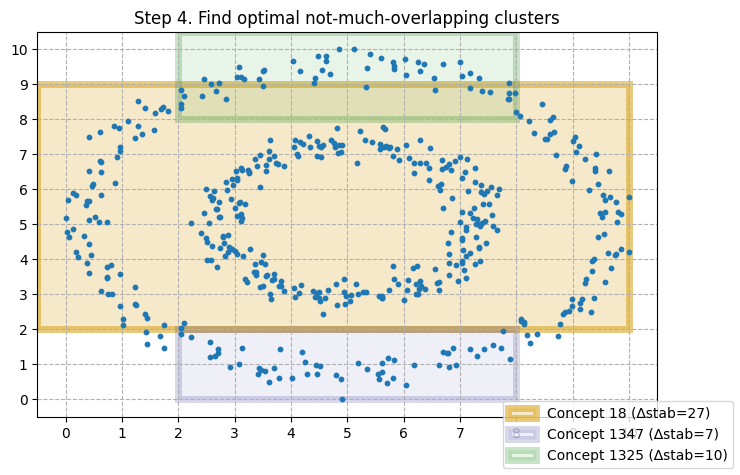

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))

k = 10
vlib.init_axis(ax, f"Step 4. Find optimal not-much-overlapping clusters", borders_per_axis[0], borders_per_axis[1], range(len(borders_per_axis[0])), range(len(borders_per_axis[1])), grid_params=dict(zorder=0, linestyle='--'))

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)

cluster_colors = ['goldenrod', 'navy', 'green', 'red', 'purple']
for concept_idx, clr in zip(clustering, cluster_colors):
    d_stab = concepts_df.at[concept_idx, 'delta_stability']/concepts_df['delta_stability'].max()
    intent = concepts_df.at[concept_idx, 'intent']
    vlib.draw_2d_description(
        ax, intent,
        patch_params=dict(
            fc=to_rgba(clr, 0.4*d_stab), ec=to_rgba(clr, 1*d_stab), linewidth=5, zorder=1, 
            label=f'Concept {concept_idx} (∆stab={concepts_df.at[concept_idx, "delta_stability"]})'
        )
    )

fig.legend(loc='lower right')
fig.savefig('../figures/pipe_step4_circlesdata.pdf')
plt.show()